# Model Training

In [87]:
# load data
import pickle
import tensorflow as tf
import pandas as pd
from tensorflow.data import Dataset
from DGMM_utils import getlabels, get_fp

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

tf.random.set_seed(358)

train_size = 800000
test_size = 80000
batch_size = 16
pad_to_len = 80

def get_ds(train_data, test_data):
    inp_train = getlabels(train_data['sfi'].values, pad_to_len)
    inp_fp = get_fp(train_data['smiles'])
    train_ds = Dataset.from_tensor_slices((inp_train, inp_fp))
    train_ds = train_ds.batch(batch_size)
    inp_test = getlabels(test_data['sfi'].values, pad_to_len)
    test_fp = get_fp(test_data['smiles'])
    test_ds = Dataset.from_tensor_slices((inp_test, test_fp))
    test_ds = test_ds.batch(batch_size)
    print(f'load train set: {len(train_data)} mols, test set {len(test_data)} mols.')
    return train_ds, test_ds

In [88]:
# df = pd.read_hdf('data/zinc_train_ext.h5')
df = pd.read_hdf('data/zinc_train.h5')

train_df = df[df['split']=='train']
test_df = df[df['split']=='test']

if len(train_df) > train_size:
    train_df = train_df.sample(n=train_size)
if len(test_df) > test_size:
    test_df = test_df.sample(n=test_size)
train_ds, test_ds = get_ds(train_df, test_df)

load train set: 150560 mols, test set 37640 mols.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from DGMM_utils import VAE
    
class lrScheduler(keras.callbacks.Callback):
    def __init__(self, ep=2, verbose=0):
        super(lrScheduler, self).__init__()
        self.verbose = verbose
        self.ep = ep

    def on_epoch_begin(self, epoch, logs=None):
        lr = float(keras.backend.get_value(self.model.optimizer.learning_rate))
        ak = float(keras.backend.get_value(self.model.ak))
        if epoch > self.ep:
            lr = lr * tf.math.exp(-0.1)
            if ak > 1e-3:
                ak = 1e-4
            else:
                self.model.ak = ak + 1e-4
            self.model.ak = ak
            self.model.optimizer.learning_rate.assign(lr)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = keras.backend.get_value(self.model.optimizer.learning_rate)
        logs['ak'] = keras.backend.get_value(self.model.ak)
        
checkpoint = keras.callbacks.ModelCheckpoint('test/DGMM_sfi.keras', monitor='loss', verbose=1, save_best_only=True)
callbacks=[keras.callbacks.TerminateOnNaN(), lrScheduler(), checkpoint]
model = VAE(pad_to_len, ak=1e-4, lr=1e-3)
model.compile()

In [92]:
his = model.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=callbacks)

Epoch 1/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - acc: 0.6282 - fp_loss: 0.3847 - kl_loss: 99.0469 - loss: 2.0989 - total_loss: 2.4935
Epoch 1: loss improved from inf to 1.99269, saving model to test/DGMM_sfi.keras
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 1380s 145ms/step - acc: 0.6282 - fp_loss: 0.3847 - kl_loss: 99.0474 - loss: 2.0989 - total_loss: 2.4935 - val_acc: 0.6740 - val_fp_loss: 0.3246 - val_loss: 87.3797 - lr: 0.0010 - ak: 1.0000e-04
Epoch 2/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - acc: 0.6891 - fp_loss: 0.3132 - kl_loss: 162.0162 - loss: 1.6978 - total_loss: 2.2550
Epoch 2: loss improved from 1.99269 to 1.60731, saving model to test/DGMM_sfi.keras
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 1363s 145ms/step - acc: 0.6891 - fp_loss: 0.3132 - kl_loss: 162.0182 - loss: 1.6978 - total_loss: 2.2550 - val_acc: 0.7287 - val_fp_loss: 0.2828 - val_loss: 68.3527 - lr: 0.0010 - ak: 1.0000e-04
Epoch 3/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - acc: 0.7331 - fp_loss: 0.2780 - kl_loss:

Epoch 17/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - acc: 0.9042 - fp_loss: 0.2019 - kl_loss: 272.5553 - loss: 0.4587 - total_loss: 1.1394
Epoch 17: loss improved from 0.47456 to 0.45516, saving model to test/DGMM_sfi.keras
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 1322s 141ms/step - acc: 0.9042 - fp_loss: 0.2019 - kl_loss: 272.5553 - loss: 0.4587 - total_loss: 1.1393 - val_acc: 0.9023 - val_fp_loss: 0.2016 - val_loss: 22.7199 - lr: 2.4660e-04 - ak: 1.0000e-04
Epoch 18/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - acc: 0.9078 - fp_loss: 0.2007 - kl_loss: 273.8309 - loss: 0.4408 - total_loss: 1.1128
Epoch 18: loss improved from 0.45516 to 0.43751, saving model to test/DGMM_sfi.keras
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 1310s 139ms/step - acc: 0.9078 - fp_loss: 0.2007 - kl_loss: 273.8310 - loss: 0.4408 - total_loss: 1.1128 - val_acc: 0.9023 - val_fp_loss: 0.2009 - val_loss: 22.8973 - lr: 2.2313e-04 - ak: 1.0000e-04
Epoch 19/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - acc: 0.9110 - fp_loss

Epoch 33/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - acc: 0.9339 - fp_loss: 0.1892 - kl_loss: 285.7608 - loss: 0.3135 - total_loss: 0.8672
Epoch 33: loss improved from 0.31577 to 0.31211, saving model to test/DGMM_sfi.keras
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 1289s 137ms/step - acc: 0.9339 - fp_loss: 0.1892 - kl_loss: 285.7608 - loss: 0.3135 - total_loss: 0.8672 - val_acc: 0.9253 - val_fp_loss: 0.1903 - val_loss: 17.7876 - lr: 4.9787e-05 - ak: 1.0000e-04
Epoch 34/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - acc: 0.9345 - fp_loss: 0.1889 - kl_loss: 285.9952 - loss: 0.3102 - total_loss: 0.8571
Epoch 34: loss improved from 0.31211 to 0.30878, saving model to test/DGMM_sfi.keras
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 1273s 135ms/step - acc: 0.9345 - fp_loss: 0.1889 - kl_loss: 285.9952 - loss: 0.3102 - total_loss: 0.8571 - val_acc: 0.9256 - val_fp_loss: 0.1901 - val_loss: 17.7406 - lr: 4.5049e-05 - ak: 1.0000e-04
Epoch 35/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - acc: 0.9352 - fp_loss

Epoch 49/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - acc: 0.9396 - fp_loss: 0.1863 - kl_loss: 288.9055 - loss: 0.2859 - total_loss: 0.7497
Epoch 49: loss improved from 0.28551 to 0.28477, saving model to test/DGMM_sfi.keras
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 1266s 135ms/step - acc: 0.9396 - fp_loss: 0.1863 - kl_loss: 288.9056 - loss: 0.2859 - total_loss: 0.7497 - val_acc: 0.9295 - val_fp_loss: 0.1880 - val_loss: 16.9739 - lr: 1.0052e-05 - ak: 1.0000e-04
Epoch 50/50
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - acc: 0.9397 - fp_loss: 0.1862 - kl_loss: 289.2179 - loss: 0.2853 - total_loss: 0.7447
Epoch 50: loss improved from 0.28477 to 0.28414, saving model to test/DGMM_sfi.keras
9410/9410 ━━━━━━━━━━━━━━━━━━━━ 1195s 127ms/step - acc: 0.9397 - fp_loss: 0.1862 - kl_loss: 289.2179 - loss: 0.2853 - total_loss: 0.7447 - val_acc: 0.9297 - val_fp_loss: 0.1879 - val_loss: 16.9480 - lr: 9.0953e-06 - ak: 1.0000e-04


In [98]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Visualizes the training history from a Keras model.fit() call.
    
    Parameters:
    history: History object returned by model.fit()
    """
    
    # 获取history中的所有metric名称
    metrics = [key for key in history.history.keys() if not key.startswith('val_')]
    
    # 创建子图，每个metric一个
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(10, 5*n_metrics))
    
    # 如果只有一个metric，确保axes是可迭代的
    if n_metrics == 1:
        axes = [axes]
    
    # 遍历每个metric
    for i, metric in enumerate(metrics):
        # 获取训练和验证数据
        train_values = history.history[metric]
        val_metric = f'val_{metric}'
        val_values = history.history.get(val_metric)
        
        # 创建epoch范围
        epochs = range(1, len(train_values) + 1)
        
        # 绘制训练数据
        axes[i].plot(epochs, train_values, 'b-', label=f'Training {metric}')
        
        # 如果有验证数据，也绘制
        if val_values:
            axes[i].plot(epochs, val_values, 'r-', label=f'Validation {metric}')
        
        # 设置标题和标签
        axes[i].set_title(f'Training and Validation {metric.capitalize()}')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True)
    
    # 调整布局防止重叠
    plt.tight_layout()
    plt.show()

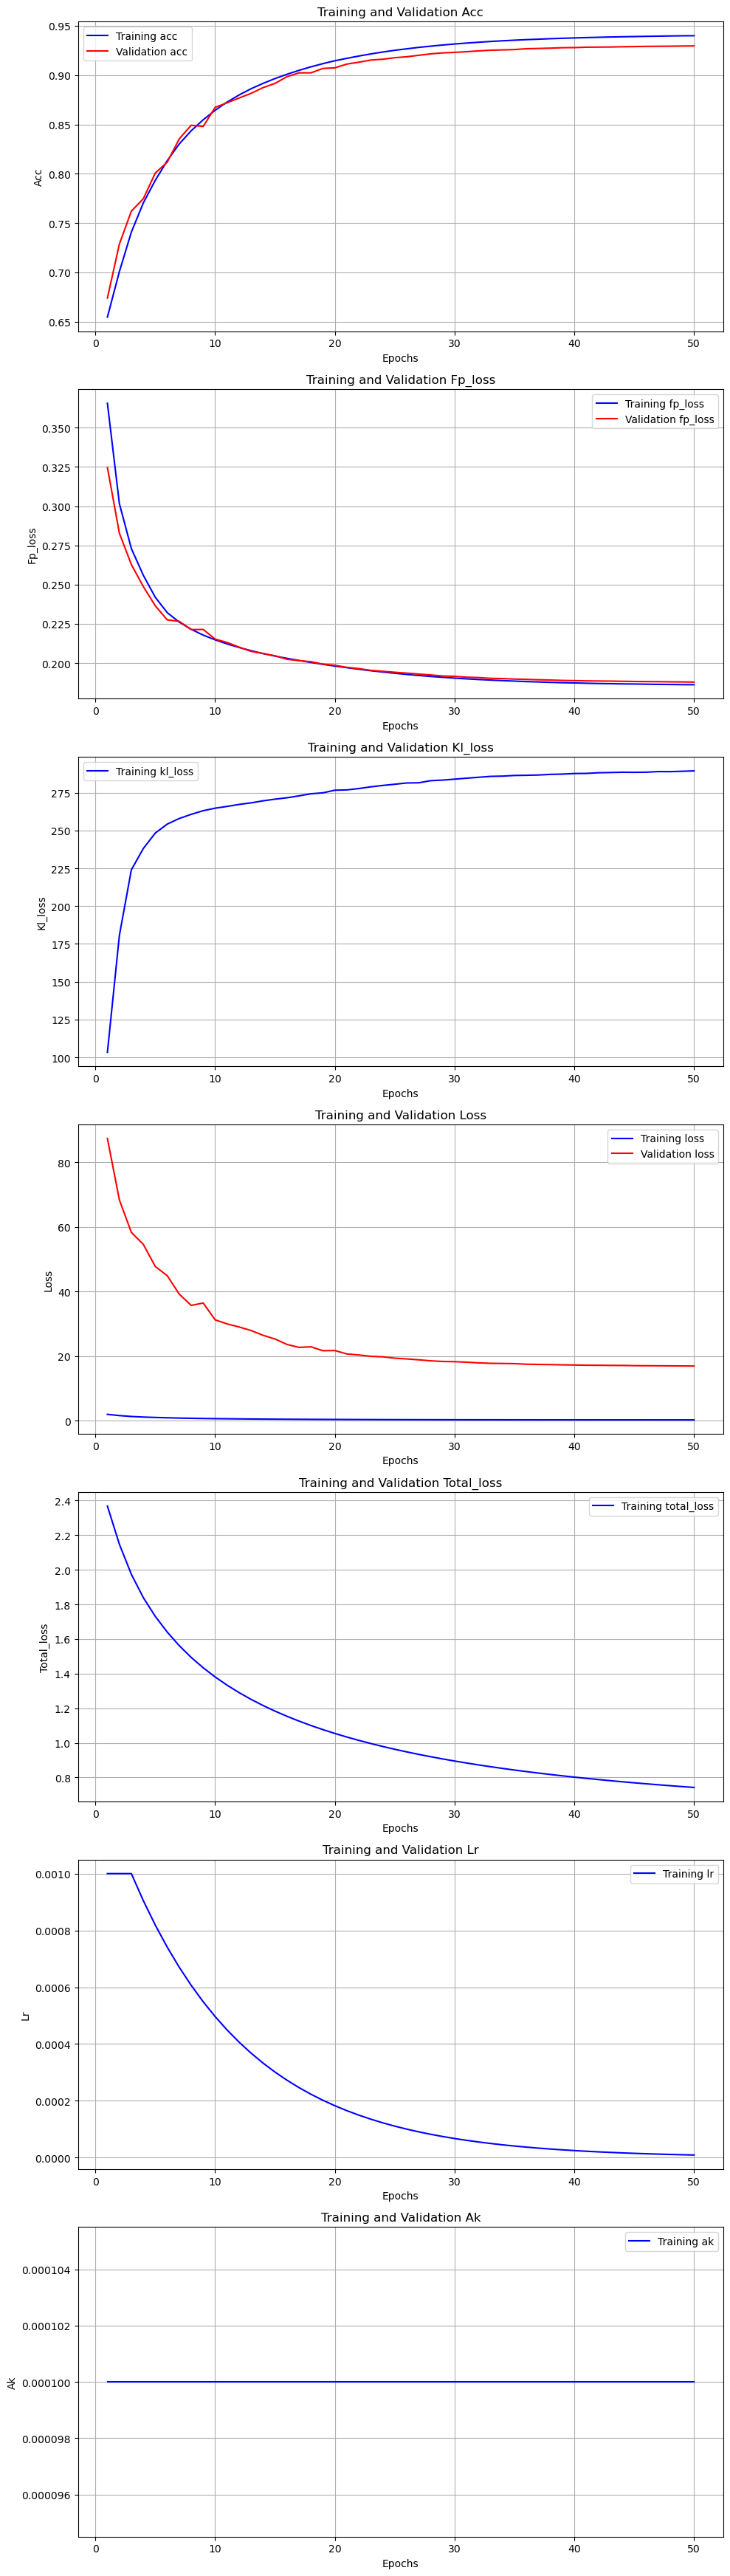

In [99]:
plot_training_history(his)

# SELFIES Test

In [21]:
import selfies as sf
import numpy as np
from DGMM_utils import alphabet, chars

def pro2sfi(data):
    res = []
    for s in data:
        sfi = ''
        for j in s:
            idx = np.random.choice(np.arange(len(alphabet)), p=j)
            token = alphabet[idx]
            if alphabet[idx].find("[nop]") > -1:
                break
            sfi+=token
        res.append(sfi)
    return res

In [22]:
from tensorflow.keras.models import load_model
from DGMM_utils import Sampling
# from keras.models import load_model
encoder = load_model(f'model/DGMM_sfi_encoder.keras', custom_objects={'Sampling':Sampling})
decoder = load_model(f'model/DGMM_sfi_decoder.keras')

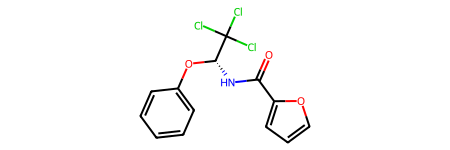

In [81]:
from rdkit import Chem
import pandas as pd
df = pd.read_hdf('data/zinc_train.h5')

sfi = df.sample(n=10)['sfi'].values
Chem.MolFromSmiles(sf.decoder(sfi[0]))

In [82]:
from DGMM_utils import getlabels
label = getlabels(sfi)
latent = encoder.predict(label, verbose=1)
pred = decoder.predict(latent[2], verbose=1)
res = pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


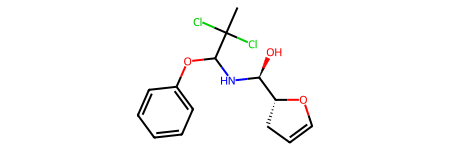

In [84]:
smi = sf.decoder(pro2sfi(res)[0])
Chem.MolFromSmiles(smi)